# imports

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Data

In [2]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/graph_features/'
file_names=os.listdir(p)

data = []

for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)

df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

In [3]:
df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))

df['date'] = pd.to_datetime(df['date'])

In [4]:
def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

def text_length(text):
    if type(text) == str:
        return len(text)
    else:
        return np.nan

df['sentiment_compound']=df['text_title'].apply(lambda x: get_sentiment(x))
df['text_length']=df['text_title'].apply(lambda x: text_length(x))

# Analysis

In [5]:
df_na = df.loc[df.awarded==0].loc[df.N_nodes!=0]
df_a = df.loc[df.awarded!=0].loc[df.N_nodes!=0]
df_no = df.loc[df.degree!=0]

### Temporal

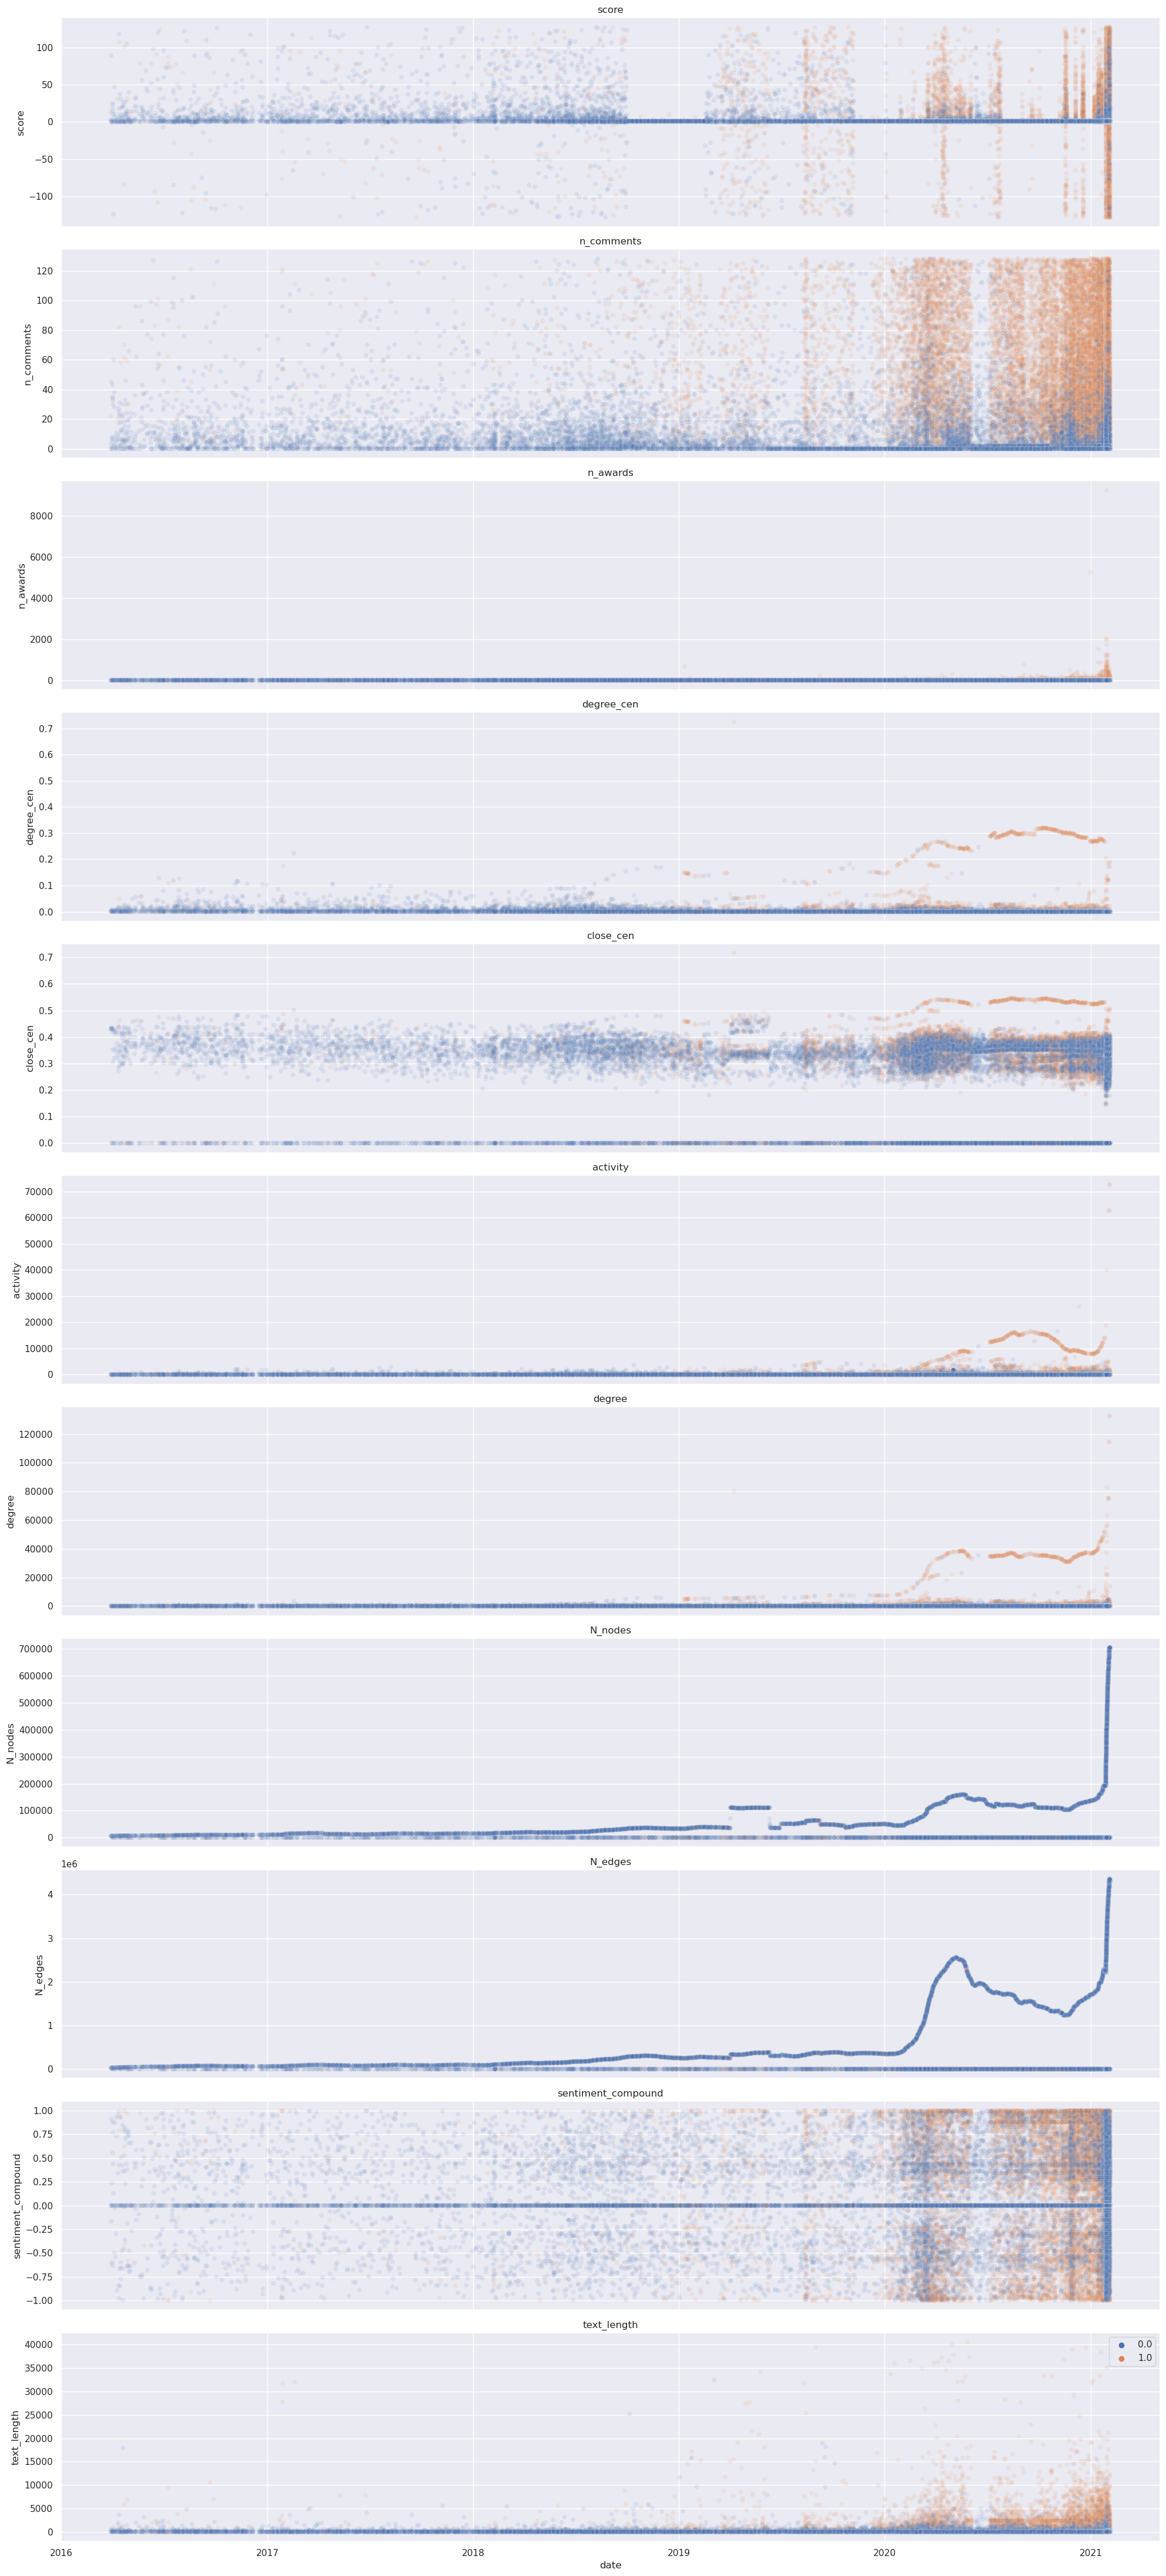

In [6]:
# subplots share x
features =['score', 'n_comments','n_awards','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges','sentiment_compound','text_length']
fig, axs = plt.subplots(len(features), 1, figsize=(20,4*len(features)), sharex=True)


for val in features:
    sns.scatterplot(data=df, x='date', y=val, hue='awarded', ax=axs[features.index(val)], alpha=0.1,s=35)
    axs[features.index(val)].set_title(val)
    # legend false
    axs[features.index(val)].get_legend().remove()

plt.legend()
plt.tight_layout()
plt.show()

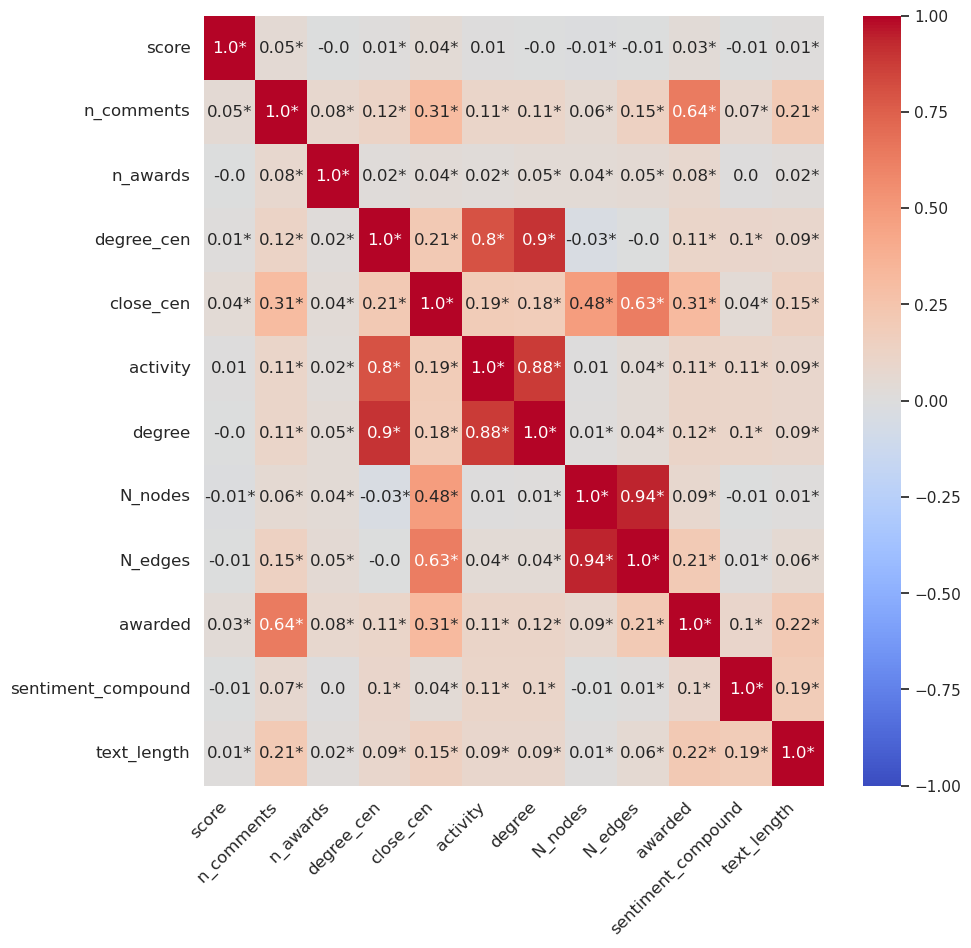

In [13]:
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t]))

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm')

# rotate xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
plt.savefig('correlation_matrix.png',dpi=300)
plt.show()

/tmp/ipykernel_3840/941695809.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_no, x=f, hue='awarded', fill=True, ax=axs[i])


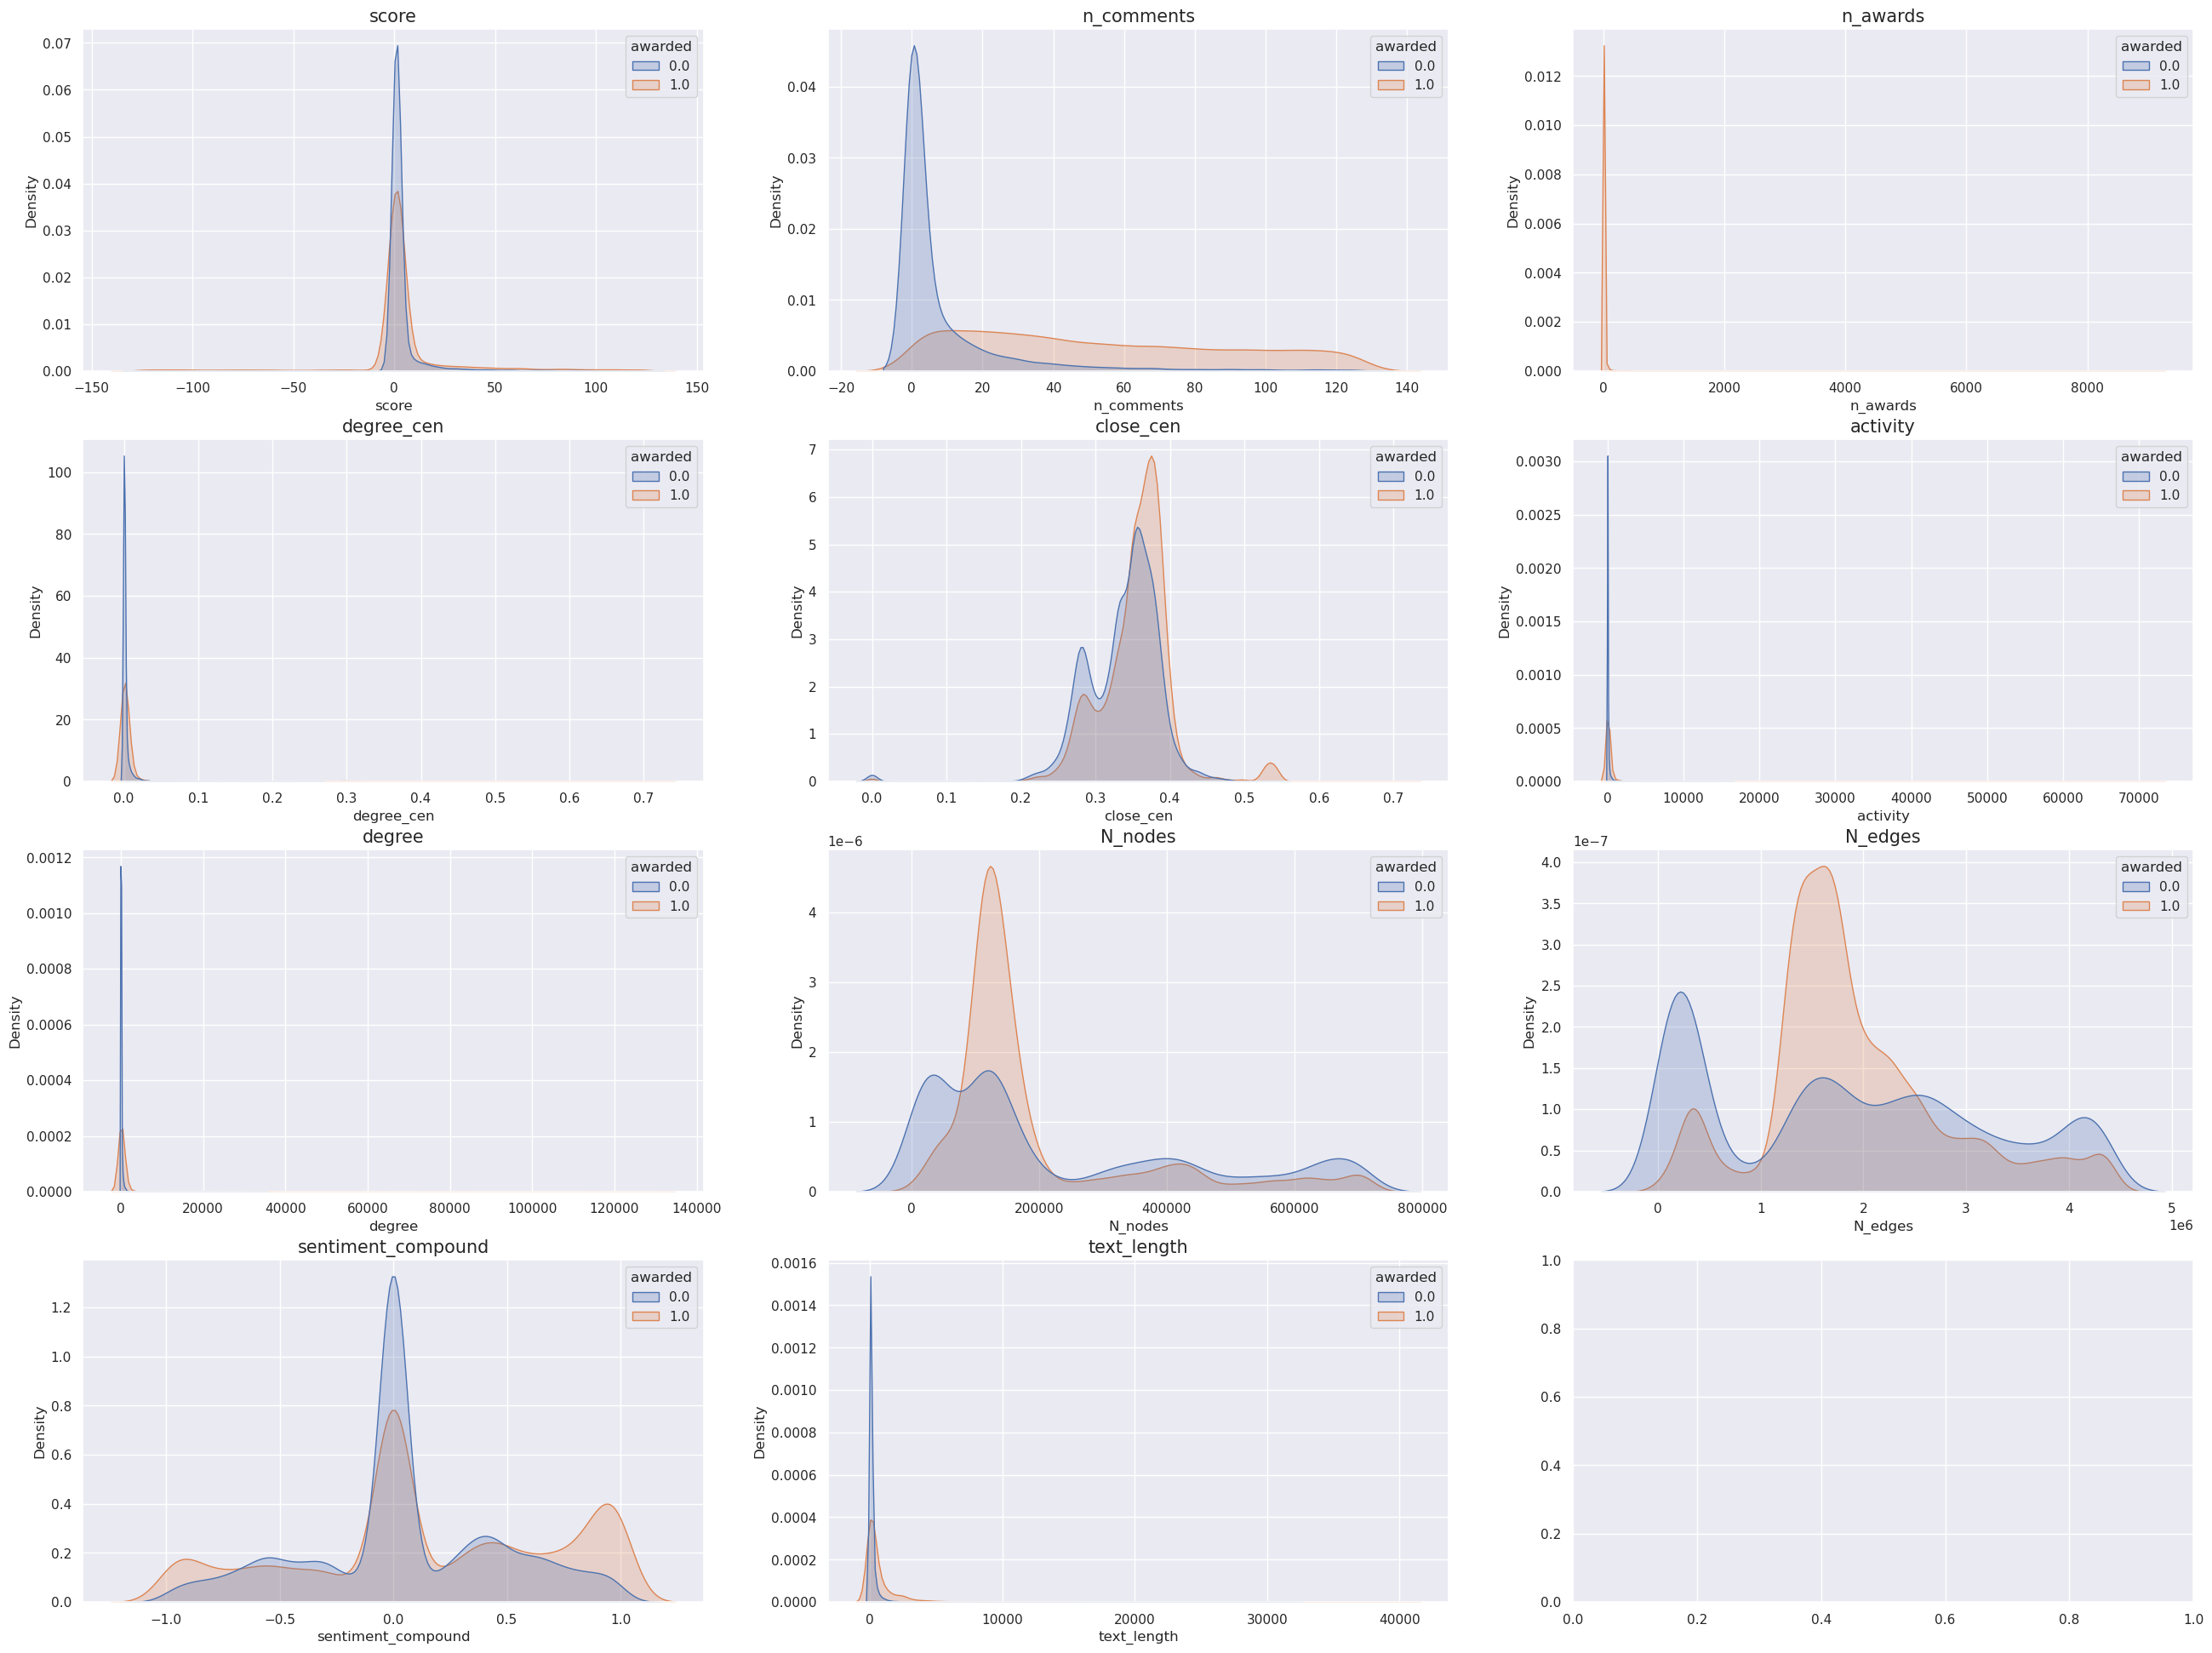

In [8]:
features = ['score', 'n_comments',  'n_awards', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length']

fig, axs = plt.subplots(4, 3, figsize=(8*4,8*3))
axs = axs.flatten()

for i in range(len(features)):
    f = features[i]
    sns.kdeplot(data=df_no, x=f, hue='awarded', fill=True, ax=axs[i])
    axs[i].set_title(f,fontsize=15)

plt.show()

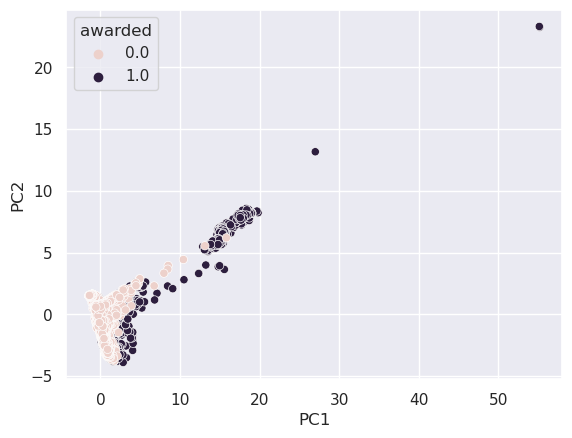

In [9]:
# pca
features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length']
scaler = StandardScaler()
scaler.fit(df[features])
df_scaled = scaler.transform(df[features])

pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

df_pca = pd.DataFrame(df_pca,columns=['PC1','PC2'])
df_pca['awarded'] = df.awarded

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='awarded')
plt.show()

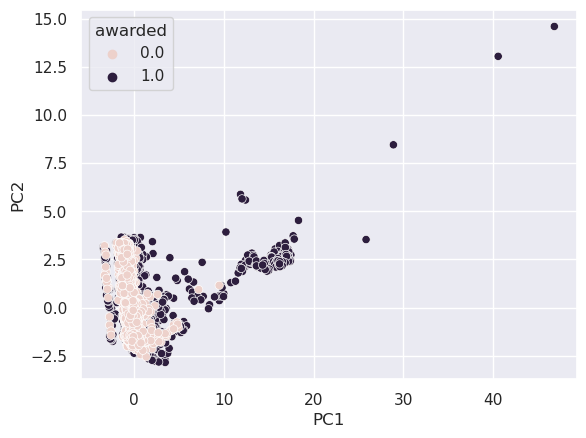

In [10]:
# pca
features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length']
scaler = StandardScaler()
scaler.fit(df_no[features])
df_no_scaled = scaler.transform(df_no[features])

pca = PCA(n_components=2)
pca.fit(df_no_scaled)
df_no_pca = pca.transform(df_no_scaled)

df_no_pca = pd.DataFrame(df_no_pca,columns=['PC1','PC2'])
df_no_pca['awarded'] = df_no.awarded

sns.scatterplot(data=df_no_pca, x='PC1', y='PC2', hue='awarded')
plt.show()

# Random Forrest

F1: 0.890648061183416


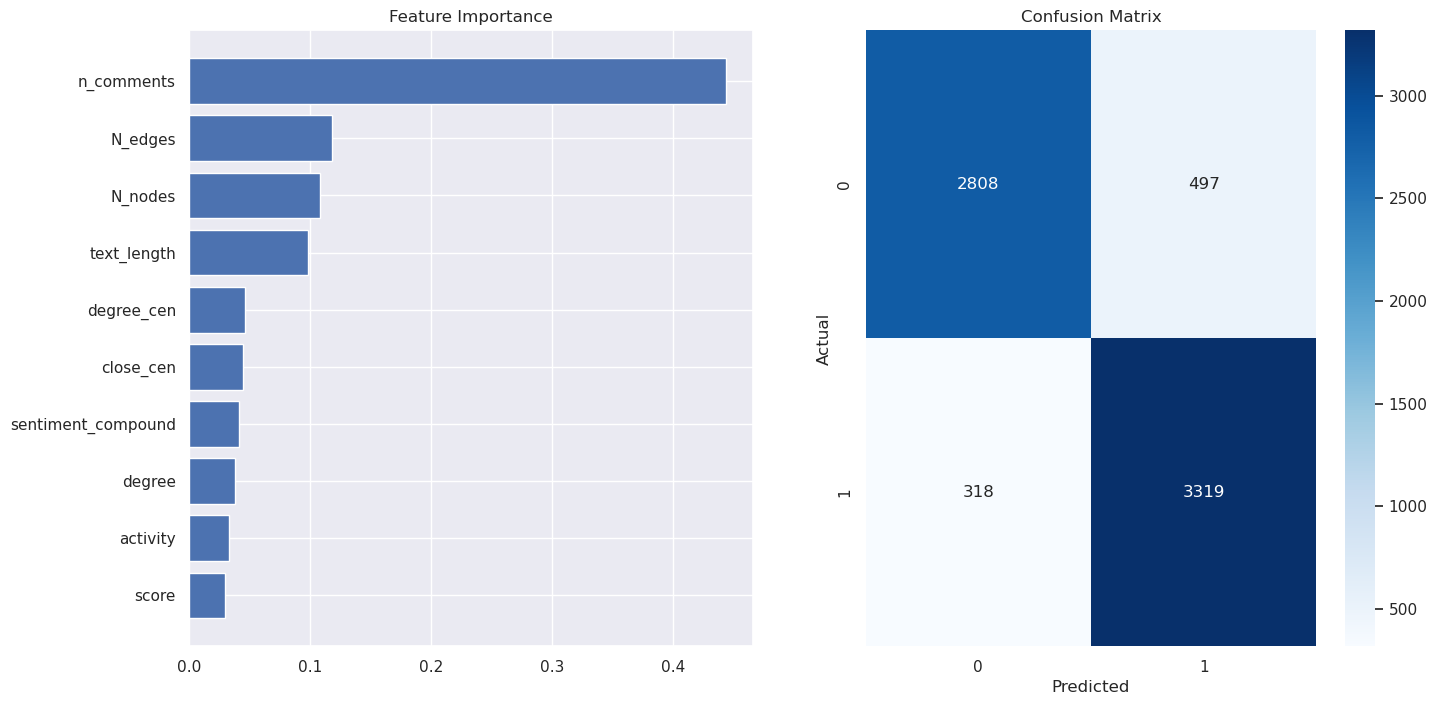

In [11]:
# make random forest to predict awarded
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length']

# split data into train and test sets
train, test = train_test_split(df_no, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']


# create model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))

# subplot with confussion matrix and feature importance side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix')

importance = rf.feature_importances_
# plot feature importance
# sort by importance
idx = np.argsort(importance)
ax1.barh([x for x in X_train.columns[idx]], importance[idx])
ax1.tick_params(axis='x', labelrotation = 0)
ax1.set_title('Feature Importance')

plt.show()

F1: 0.748138517905685


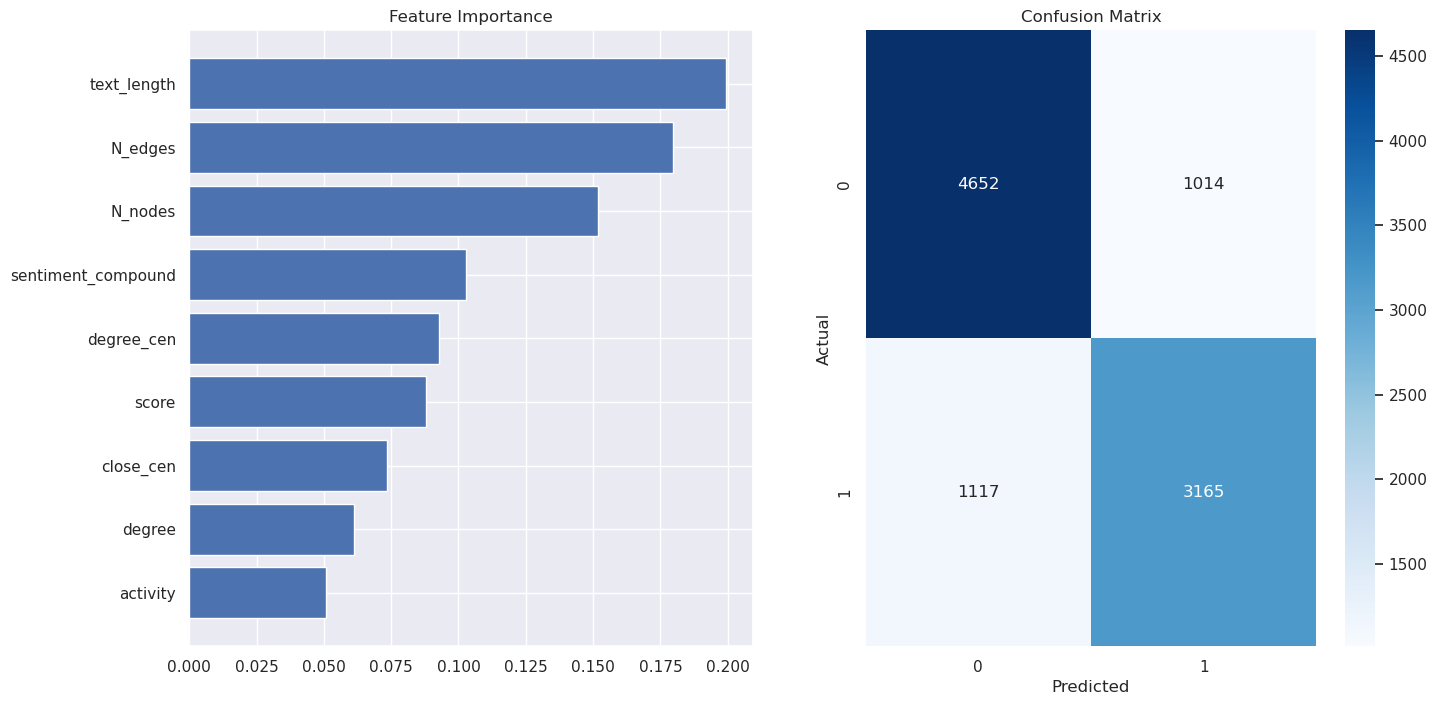

In [12]:
# make random forest to predict awarded
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

features = ['score', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']


# create model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))

# subplot with confussion matrix and feature importance side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix')

importance = rf.feature_importances_
# plot feature importance
# sort by importance
idx = np.argsort(importance)
ax1.barh([x for x in X_train.columns[idx]], importance[idx])
ax1.tick_params(axis='x', labelrotation = 0)
ax1.set_title('Feature Importance')

plt.show()

# Log reg

F1: 0.5922094714724423


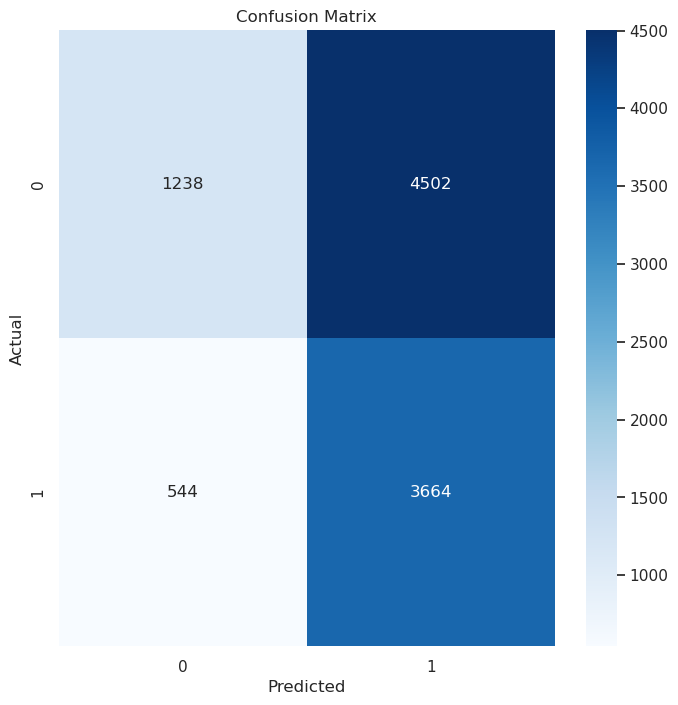

In [19]:
# logistic regression
from sklearn.linear_model import LogisticRegression

features = ['score', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']

# create model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# predict
y_pred = logreg.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))


plt.figure(figsize=(8,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()